This script generates the scatter plots presented in fig2 and fig s2-s4

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
sns.set(font_scale = 1.2)
sns.set_style('white')

### Plots for HLCA

In [3]:
table = pd.read_csv("results/eval/performances_HLCA_loo_polyEN.csv")

In [4]:
smoker_table = table.loc[table["group"] == "smoker",].copy()
nonsmoker_table = table.loc[table["group"] == "nonsmoker",].copy()

In [5]:
def reformat(table):
    dfs = []
    n_rep = 5
    for i,(ct,df) in enumerate(table.groupby("cell_type")): # Iterate over each cell type
        ct_df = []
        for (gene_type,use_pca),dff in df.groupby(["gene_type","use_pca"]): # Iterate over gene_type and use_pca for within each cell type
            if dff.iloc[0,:]["pred_age"] is not np.nan:
                ages = []
                for idx,row in dff.iterrows():
                    ages.append(np.array([float(age) for age in row["pred_age"].split(",")]))
                ages = np.vstack(ages)
                pred_age = ages.mean(axis = 0)
                dff["pred_age_mean"] = ",".join([str(age) for age in pred_age])
                dff["R2_mean"] = dff["R2"].mean()
                ct_df.append(dff)
        
        if len(ct_df) != 0: # If no gene_type and use_pca contains valid predictions, the current cell type will be skipped.
            ct_df = pd.concat(ct_df)    
            ct_df.sort_values(by = "R2_mean",ascending = False,inplace=True)
            ct_df = ct_df.iloc[0:n_rep,] # pick the best one for each cell type
            ct_df["ind"] = str(i)
            dfs.append(ct_df)
        
    table = pd.concat(dfs)
    
    del(table["R2"],
        table["rep"],
        table["pred_age"]
       )
    
    if "MAE" in table.columns:
        del(table["MAE"])
        
    table.drop_duplicates(inplace=True)
    table.sort_values(by = "R2_mean", ascending = False, inplace = True)
    
    return(table)

In [6]:
def plot_scatter(plt_data, title, nrows, n_cell_type):
    
    fig,axs = plt.subplots(nrows=nrows, ncols = 4, figsize = (15,3.75*nrows))
    plt_data = plt_data.iloc[:n_cell_type,].copy().reset_index(drop = True)
    
    for i in range(nrows*4):
        row_idx = int(i/4)
        col_idx = i%4
        ax = axs[row_idx, col_idx]
        if i < n_cell_type:
            row = plt_data.iloc[i,]
            true_ages = [float(age) for age in row["true_age"].split(",")]
            pred_ages = [float(age) for age in row["pred_age_mean"].split(",")]
            show_text = f"Mean of $R^2$: {np.round(row['R2_mean'],3)}"

            sns.regplot(x=true_ages,y=pred_ages, ax=ax)
            ax.plot([20,80],[20,80])
            ax.text(0.99, 0.03, show_text,
                horizontalalignment='right',
                verticalalignment='bottom',
                transform=ax.transAxes)

            plt.axis('equal')
            ax.set_xlabel('True age (years)')
            ax.set_ylabel('Predicted age (years)')
            ax.set_title(f"{row['cell_type']}")
            ax.set_xticks([20,35,50,65,80])
            ax.set_yticks([20,35,50,65,80])
            sns.despine()
        else:
            ax.axis('off') # Hide unplotted subplots
    
    fig.suptitle(title, fontweight = 'bold')
    plt.tight_layout()
    return fig

In [7]:
smoker_plt_data = reformat(smoker_table)
nonsmoker_plt_data = reformat(nonsmoker_table)

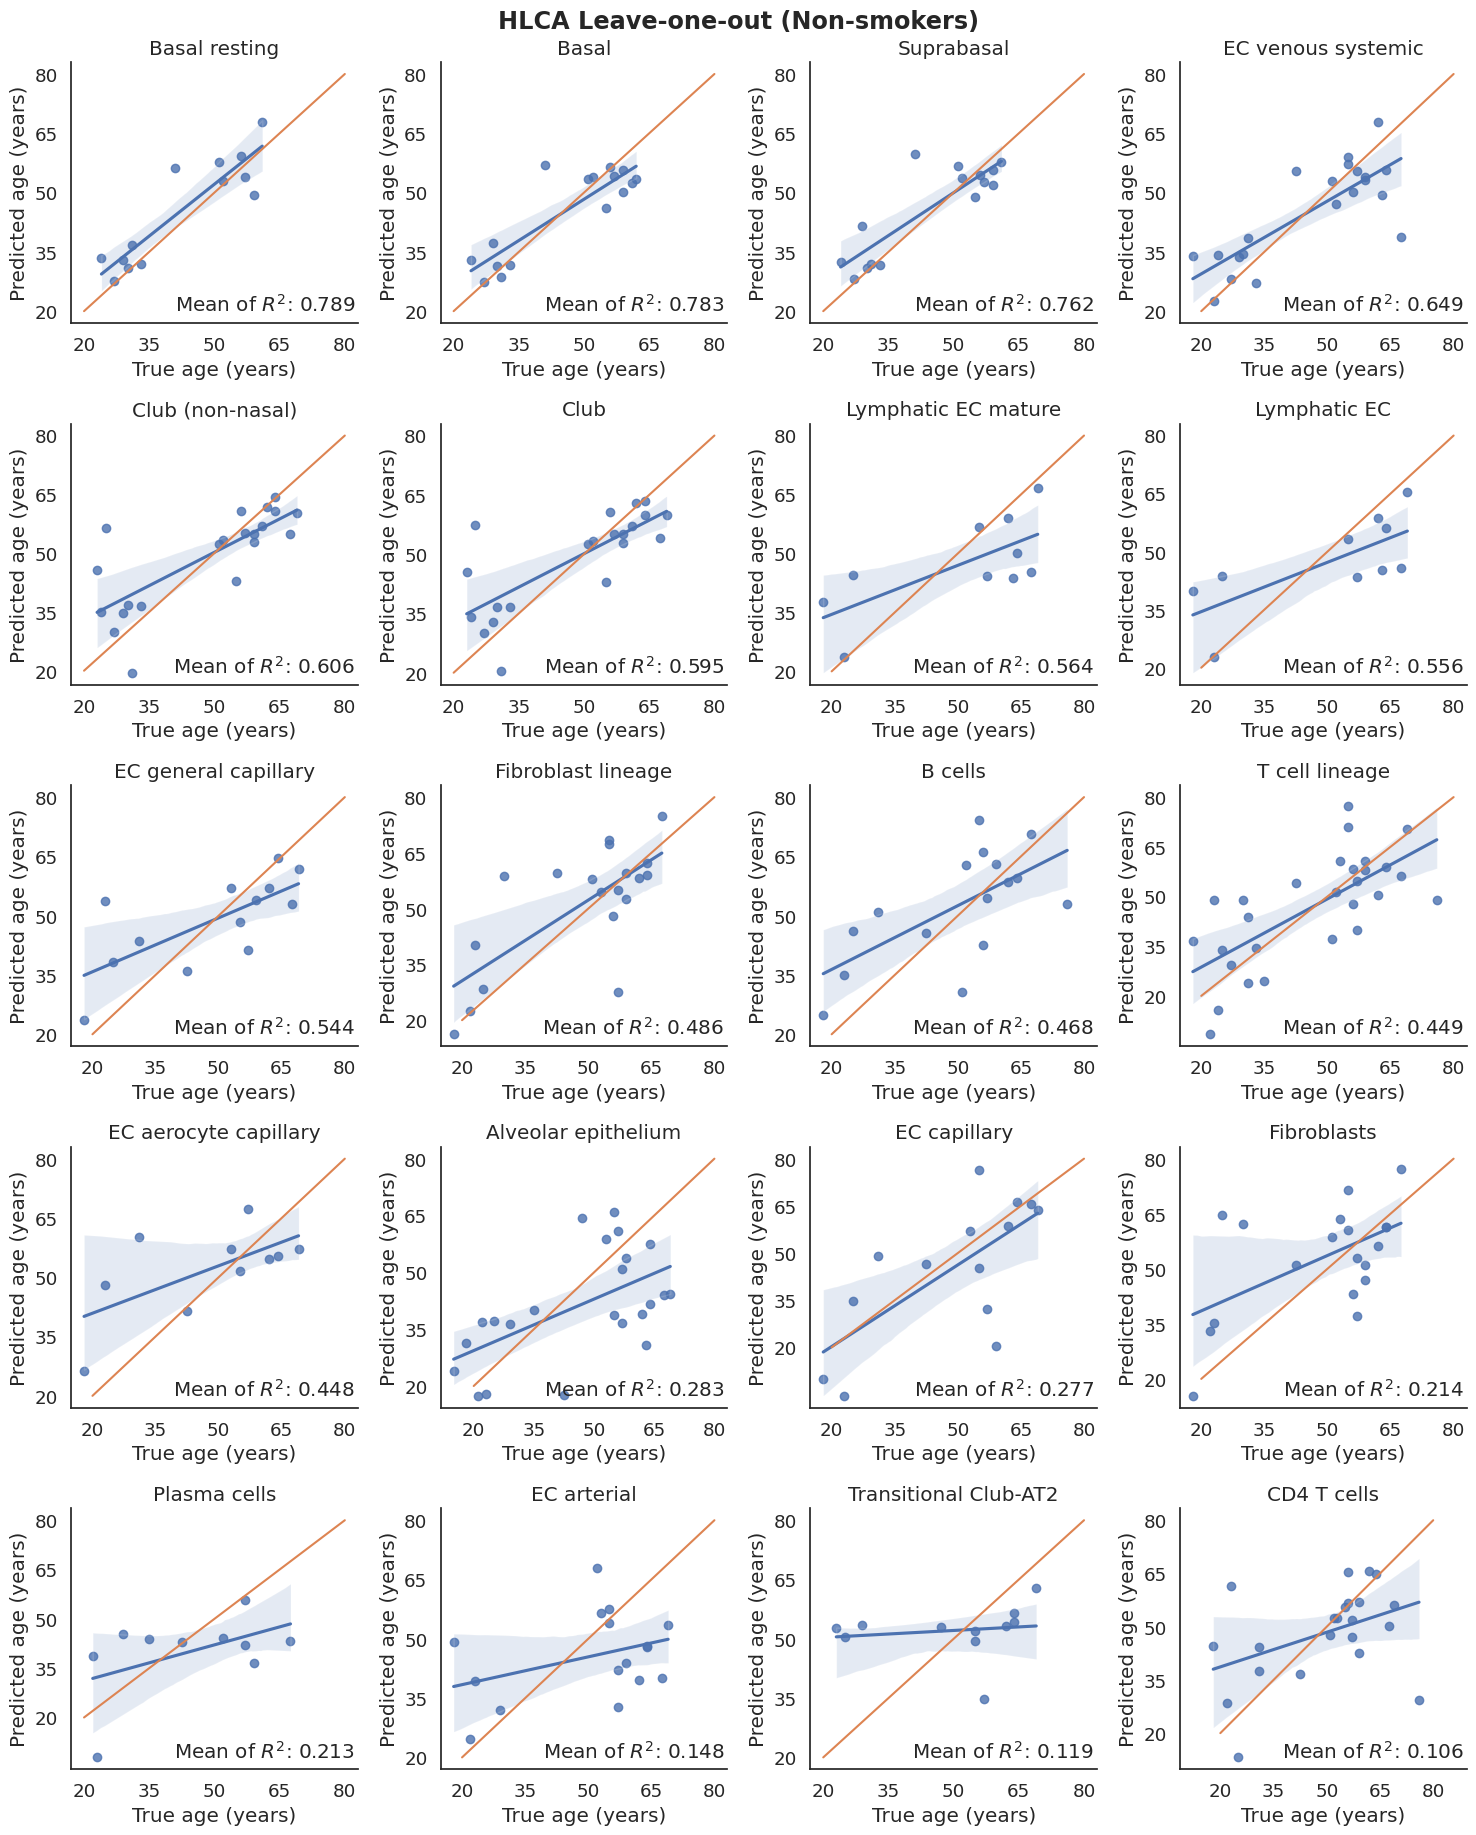

In [14]:
fig = plot_scatter(nonsmoker_plt_data, title = "HLCA Leave-one-out (Non-smokers)", nrows = 5, n_cell_type=20)
if not os.path.isdir("results/figs"):
    os.mkdir("results/figs")
fig.savefig("results/figs/scatter_hlca_nonsmoker.svg")

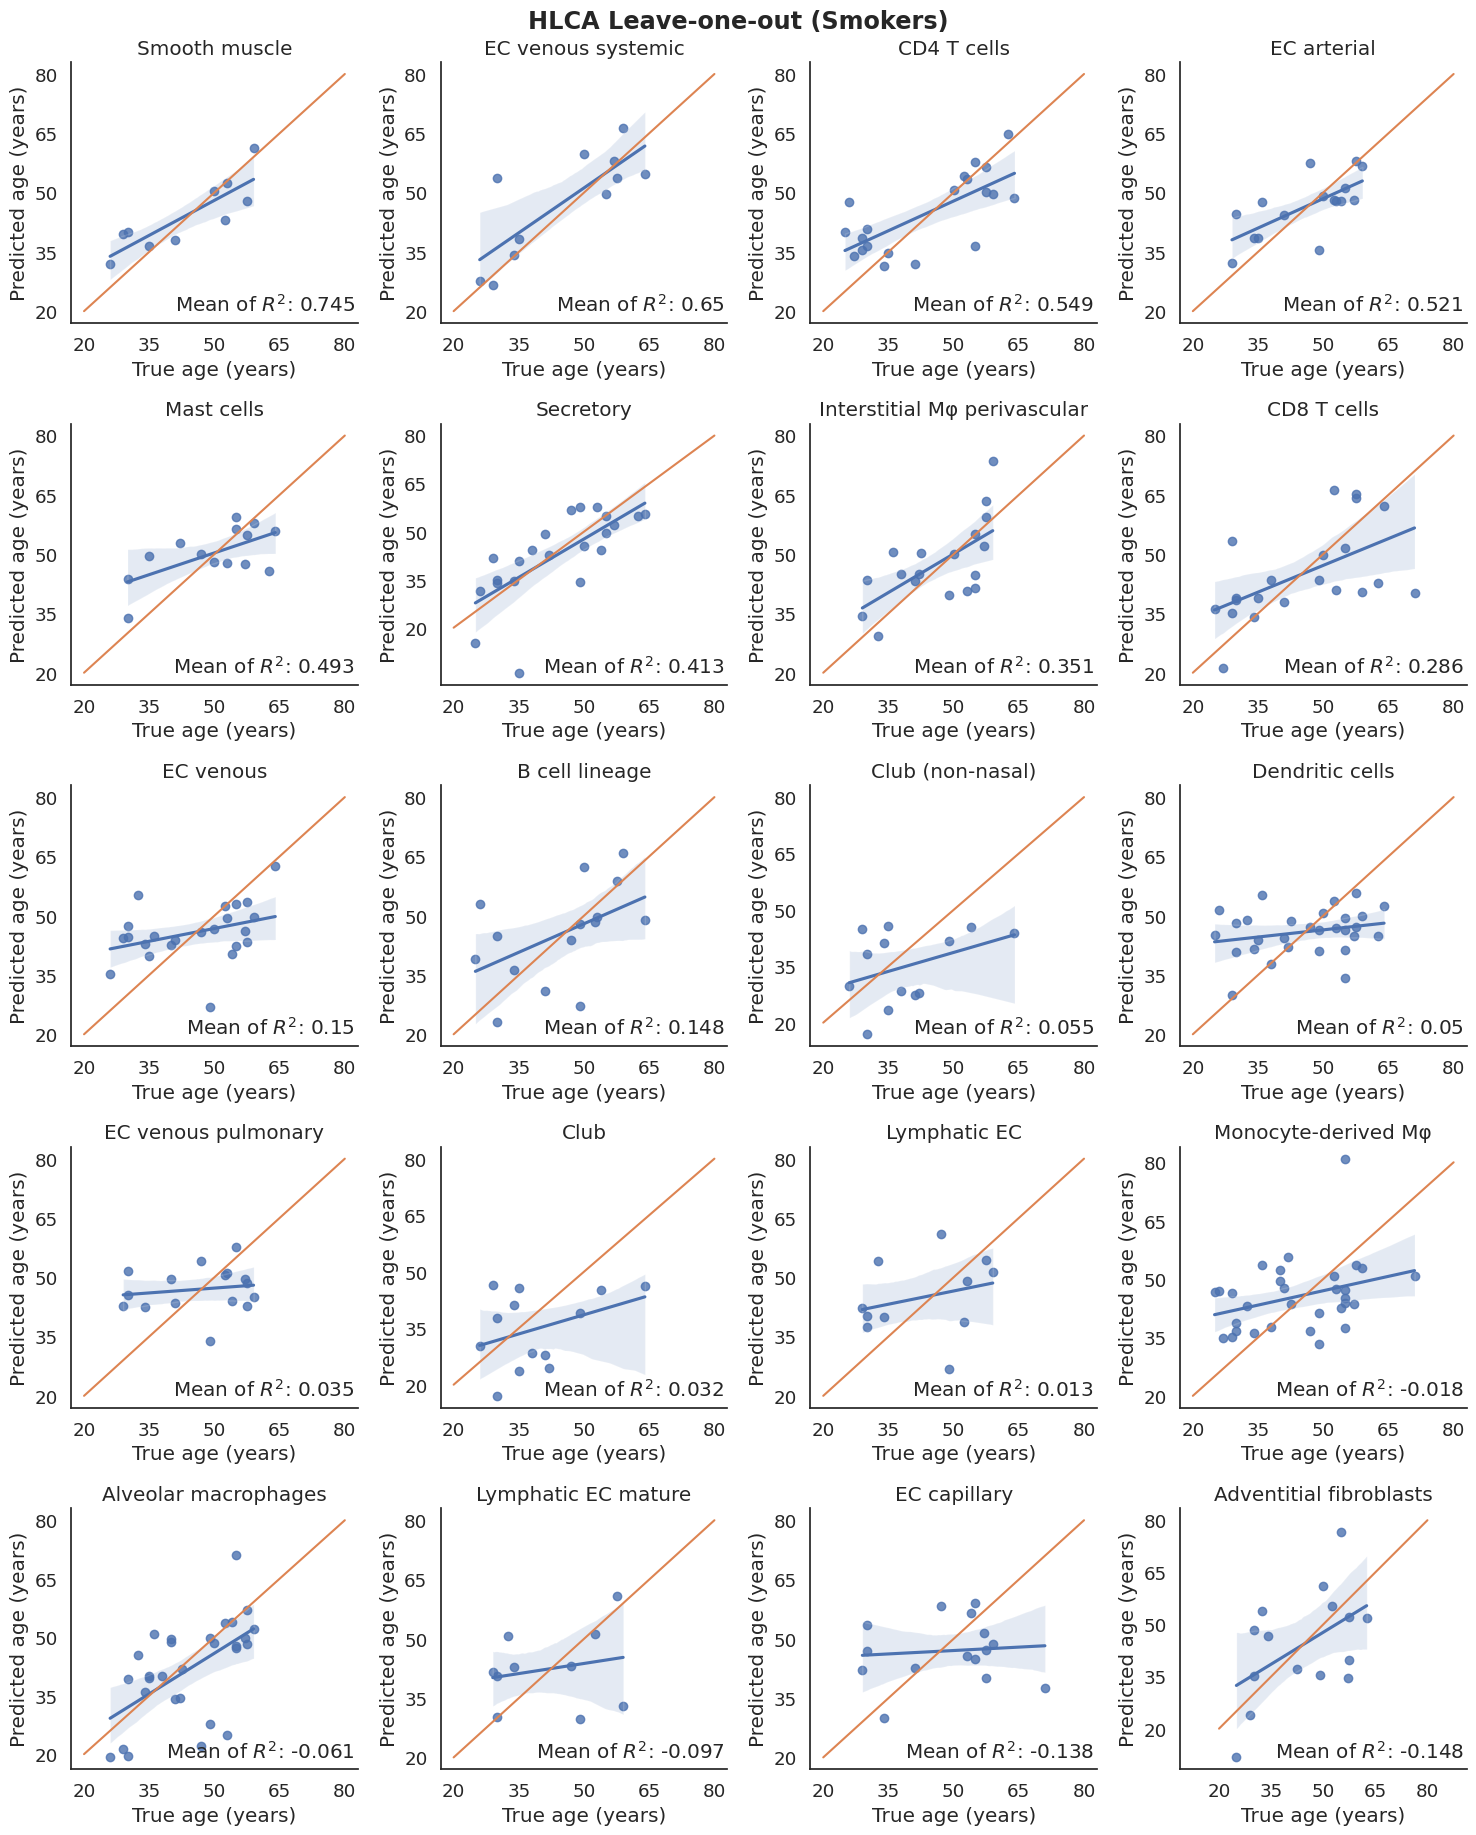

In [15]:
fig = plot_scatter(smoker_plt_data, title = "HLCA Leave-one-out (Smokers)",nrows = 5, n_cell_type=20)
if not os.path.isdir("results/figs"):
    os.mkdir("results/figs")
fig.savefig("results/figs/scatter_hlca_smoker.svg")

### Plot for cross-dataset test

In [10]:
table = pd.read_csv("results/eval/performance_CD_polyEN.csv",index_col = 0).reset_index(drop = True)

In [11]:
smoker_table = table.loc[table["group"] == "smoker",].copy()
nonsmoker_table = table.loc[table["group"] == "nonsmoker",].copy()

In [12]:
smoker_plt_data = reformat(smoker_table)
nonsmoker_plt_data = reformat(nonsmoker_table)

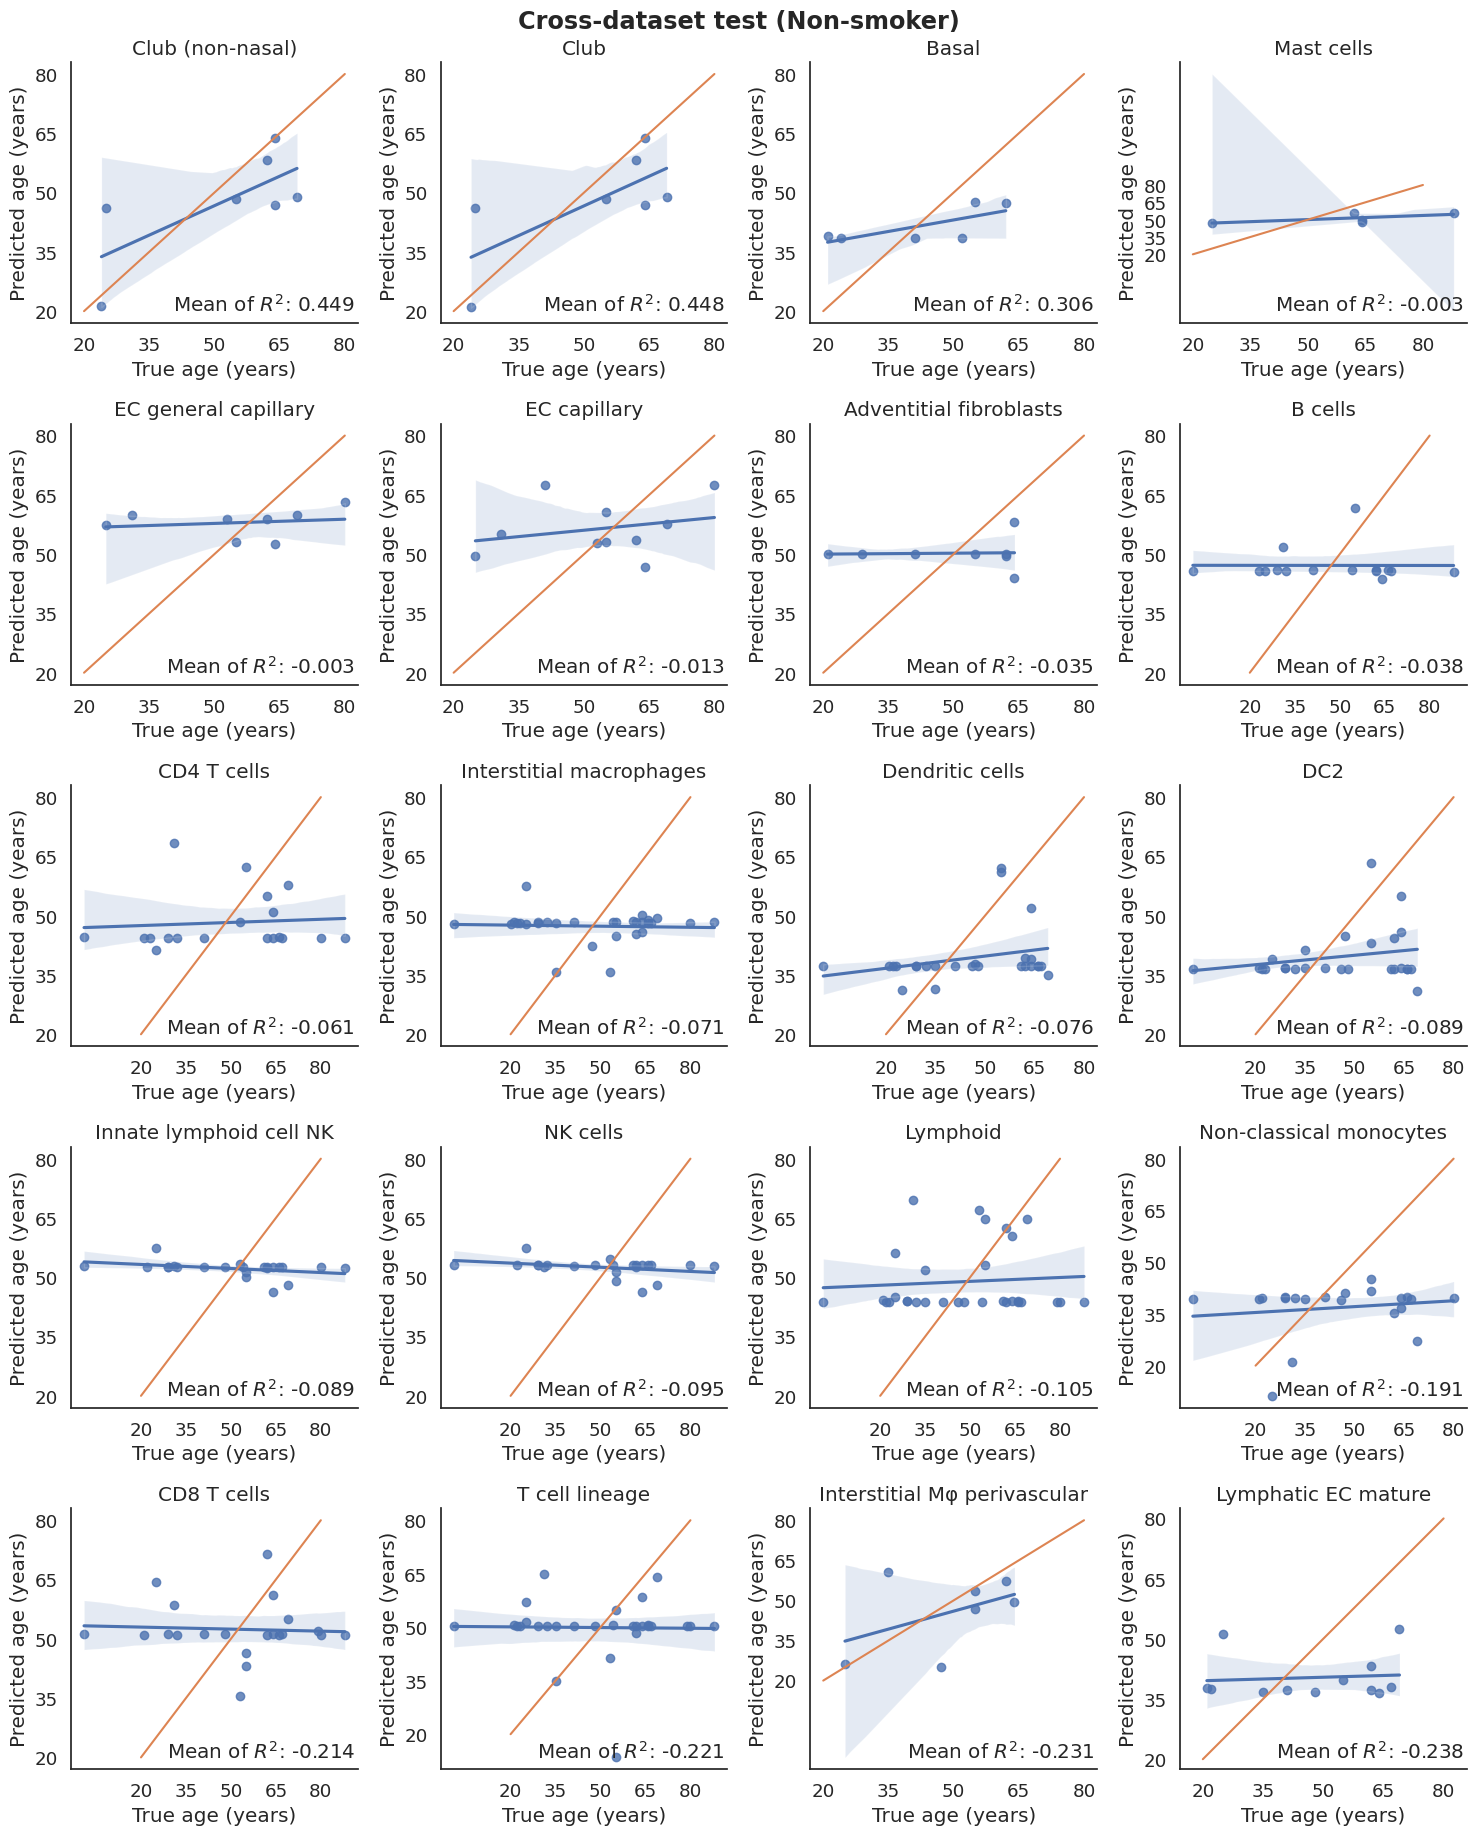

In [13]:
fig = plot_scatter(nonsmoker_plt_data, title = "Cross-dataset test (Non-smoker)",nrows = 5, n_cell_type=20)
if not os.path.isdir("results/figs"):
    os.mkdir("results/figs")
fig.savefig("results/figs/scatter_cd_nonsmoker.svg")

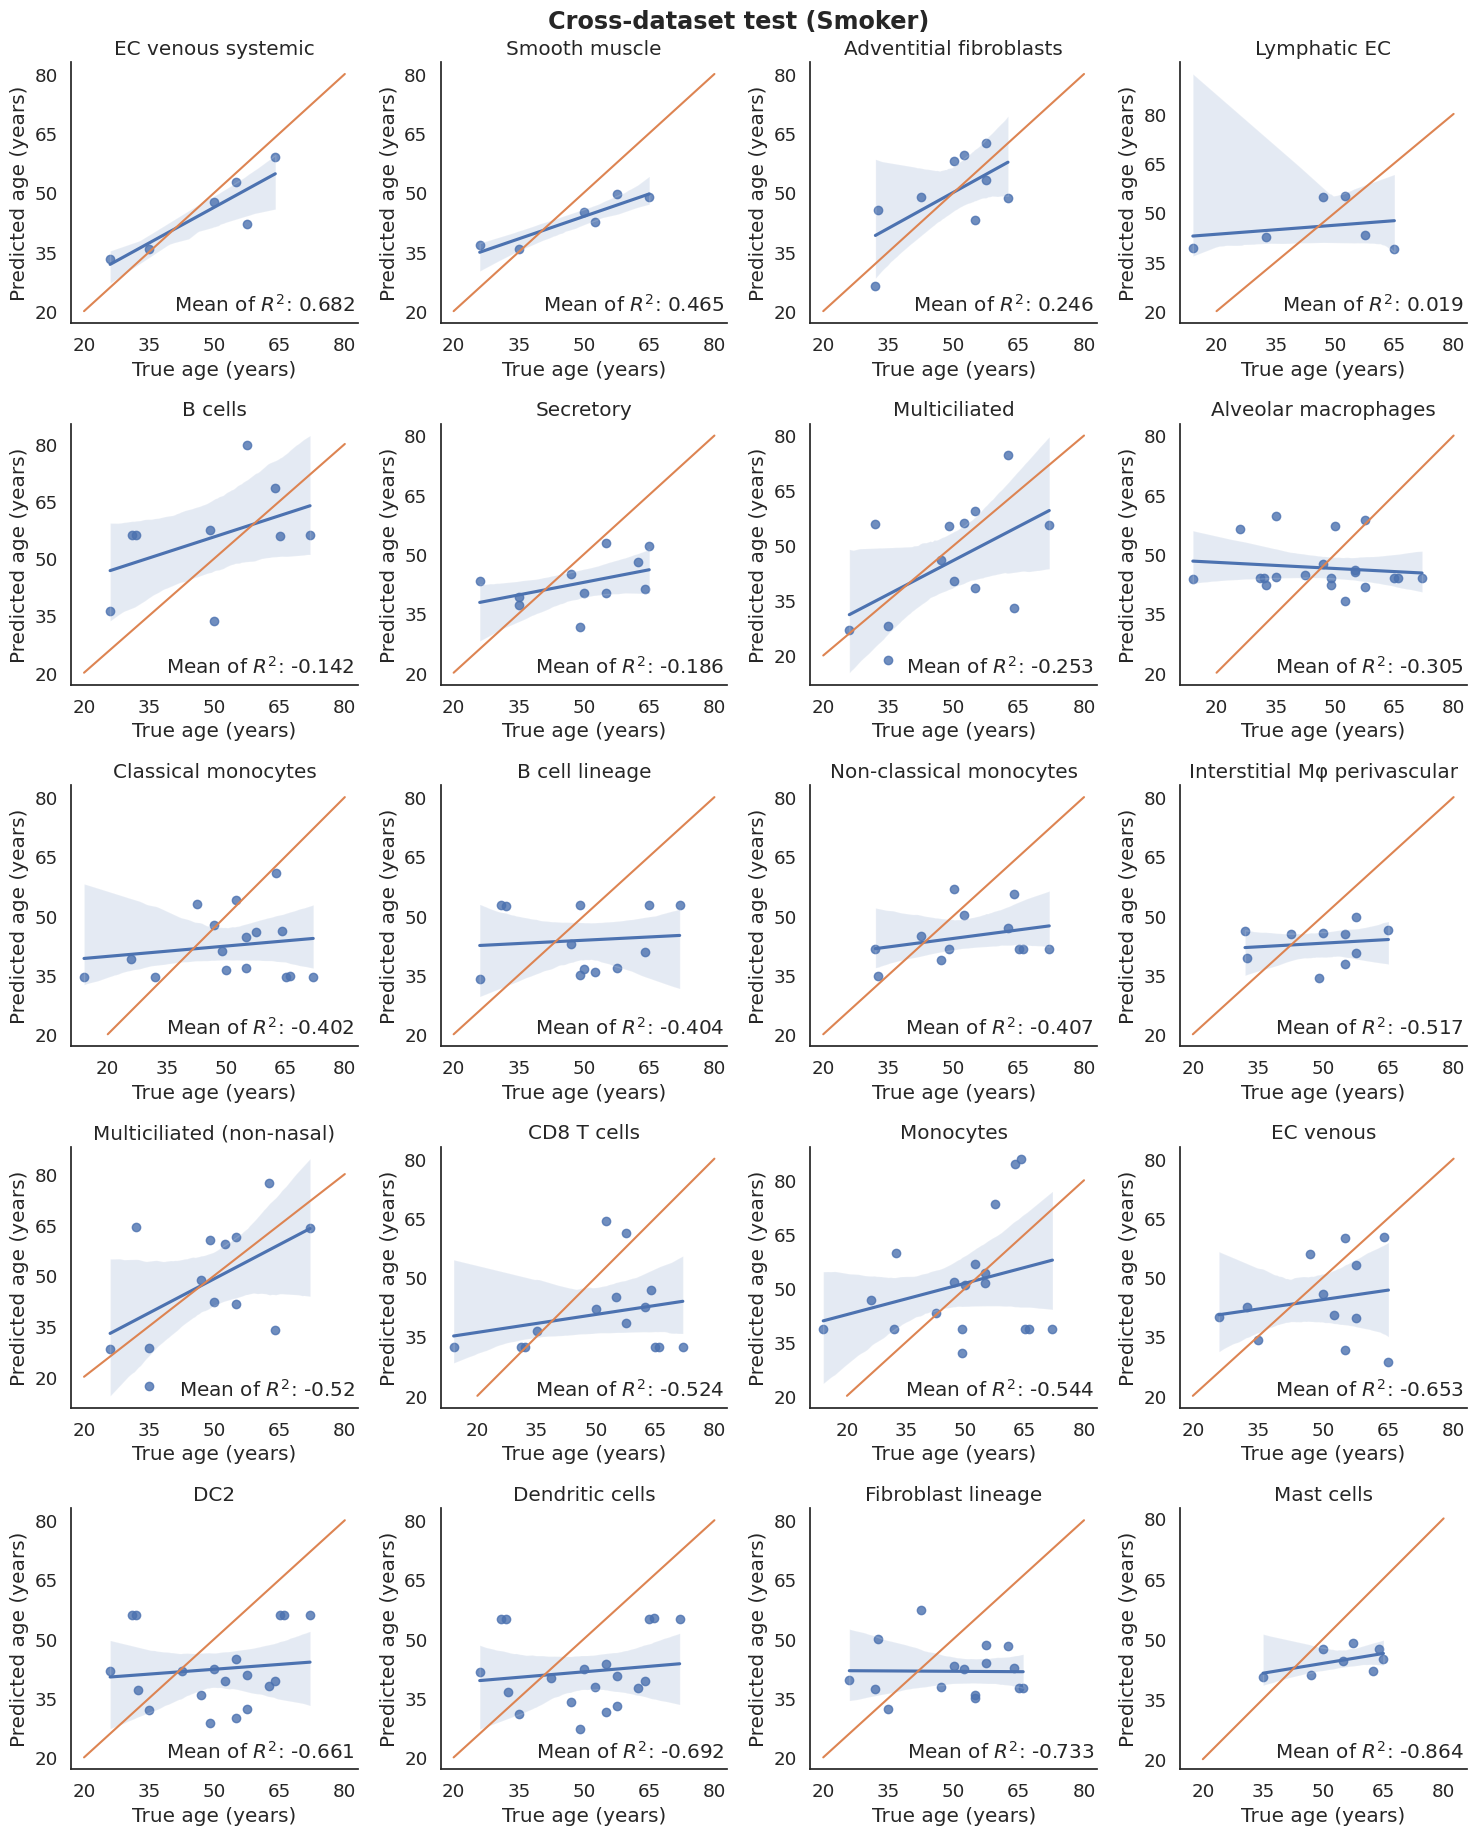

In [14]:
fig = plot_scatter(smoker_plt_data, title = "Cross-dataset test (Smoker)",nrows = 5, n_cell_type=20)
if not os.path.isdir("results/figs"):
    os.mkdir("results/figs")
fig.savefig("results/figs/scatter_cd_smoker.svg")

### Plot for Nuc-seq

In [15]:
table = pd.read_csv("results/eval/performances_nucseq_loo_polyEN.csv").reset_index(drop = True)

In [16]:
table["cell_type"] = table["Cell type(Nuc-seq)"]

In [17]:
smoker_table = table.loc[table["Group"] == "smoker",].copy()
nonsmoker_table = table.loc[table["Group"] == "nonsmoker",].copy()

In [18]:
nonsmoker_plt_data = reformat(nonsmoker_table)

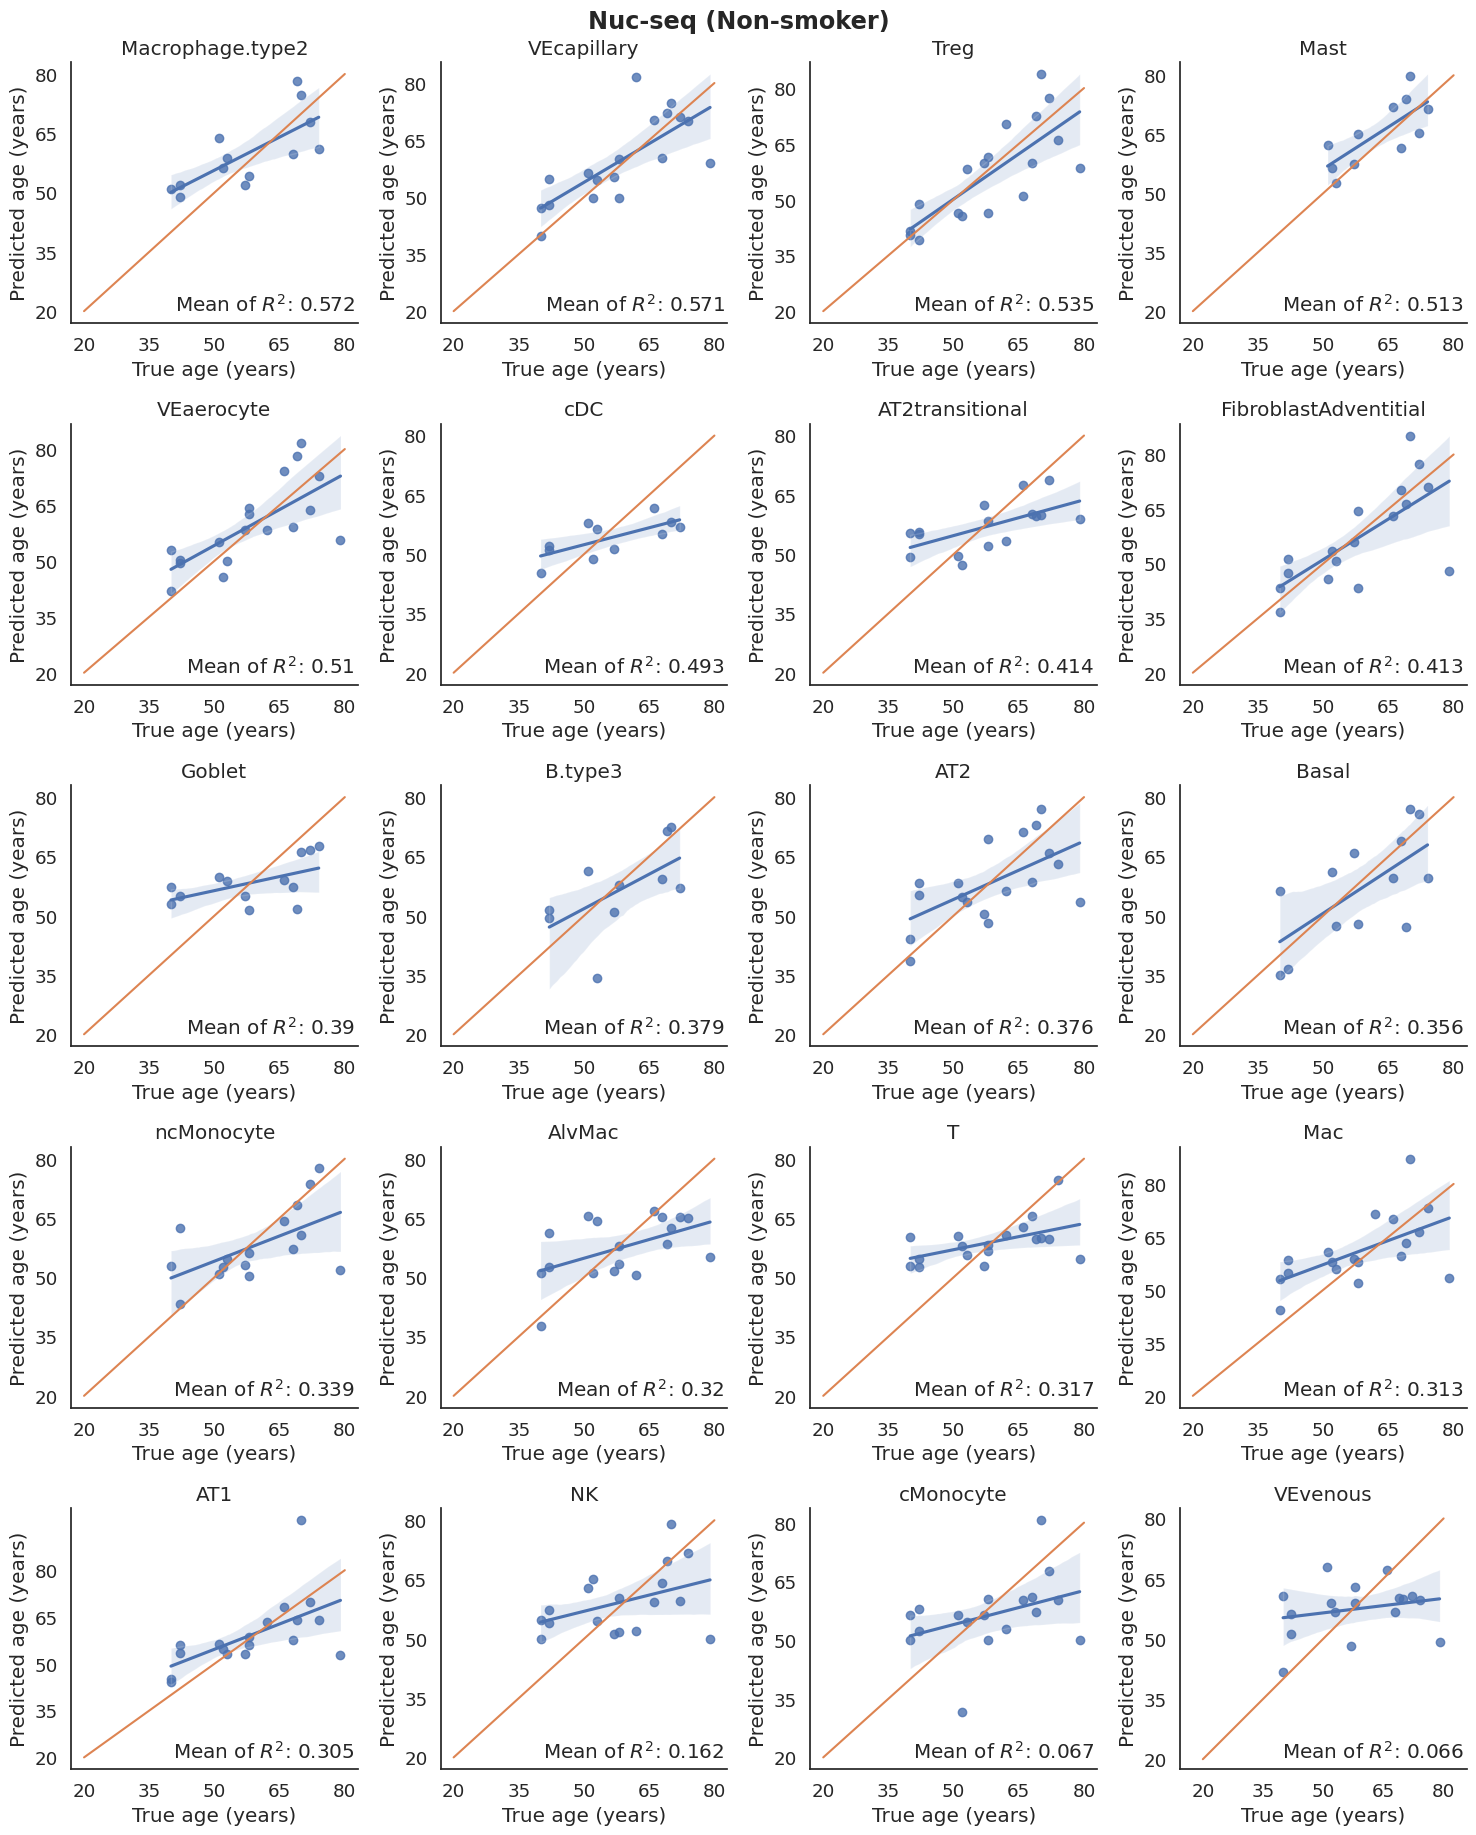

In [19]:
fig = plot_scatter(nonsmoker_plt_data, title="Nuc-seq (Non-smoker)", nrows=5, n_cell_type = 20)
fig.savefig("results/figs/scatter_nuc_nonsmoker.svg")